In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download mohamedmaher5/vehicle-classification

Dataset URL: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification
License(s): CC0-1.0
 83% 690M/827M [00:03<00:02, 52.7MB/s]
100% 827M/827M [00:04<00:00, 213MB/s] 


In [4]:
!unzip /content/vehicle-classification.zip -d Vehicles

Streaming output truncated to the last 5000 lines.
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (630).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (631).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (632).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (633).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (634).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (635).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (636).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (637).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (638).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (639).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (64).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (640).jpg  
  inflating: Vehicles/Vehicles/Auto Rickshaws/Auto Rickshaw (641).jpg  
  inflating: V

# **EfficientNetB0**

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [48]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = "/content/Vehicles/Vehicles"

In [49]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

In [50]:
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

Found 4470 images belonging to 7 classes.


In [51]:
val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 1117 images belonging to 7 classes.


In [52]:
NUM_CLASSES = train_generator.num_classes
print(train_generator.class_indices)

{'Auto Rickshaws': 0, 'Bikes': 1, 'Cars': 2, 'Motorcycles': 3, 'Planes': 4, 'Ships': 5, 'Trains': 6}


In [53]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [54]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)

In [55]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [56]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,562 (16.10 MB)

 Trainable params: 167,431 (654.03 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [57]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "vehicle_efficientnet_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [58]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.4689 - loss: 1.7640
Epoch 1: val_accuracy improved from -inf to 0.96509, saving model to vehicle_efficientnet_best.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 151s 881ms/step - accuracy: 0.4703 - loss: 1.7588 - val_accuracy: 0.9651 - val_loss: 0.3501 - learning_rate: 1.0000e-04
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.8966 - loss: 0.3220
Epoch 2: val_accuracy improved from 0.96509 to 0.98030, saving model to vehicle_efficientnet_best.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 89s 636ms/step - accuracy: 0.8967 - loss: 0.3217 - val_accuracy: 0.9803 - val_loss: 0.0931 - learning_rate: 1.0000e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9346 - loss: 0.2099
Epoch 3: val_accuracy improved from 0.98030 to 0.98389, saving model to vehicle_efficientnet_best.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 91s 638ms/step - accuracy: 0.9346 - loss: 0.2098 - val_accuracy: 0.9839 - val_loss: 0.0563 - learning

# **Plotting Train vs Validation Loss & Accuracy**

In [59]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.show()


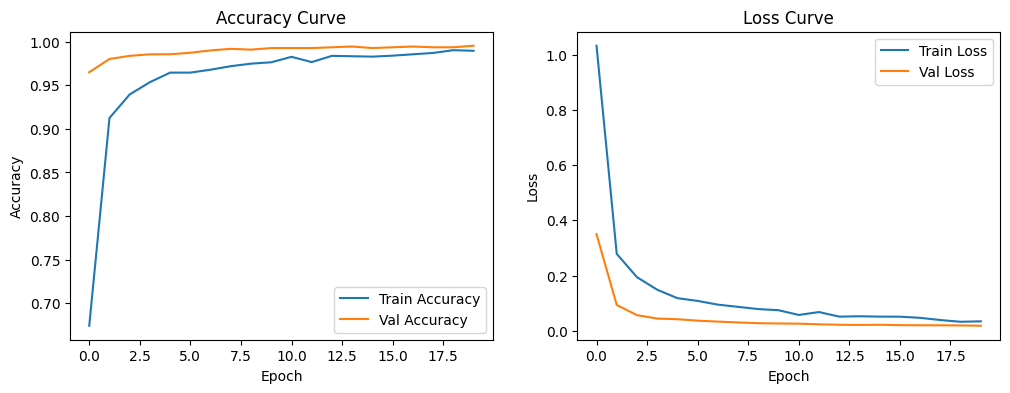

In [60]:
plot_training_curves(history)

# **Confusion Matrix on Validation Set**

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


val_generator.reset()

y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = list(val_generator.class_indices.keys())

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step


In [62]:
cm = confusion_matrix(y_true, y_pred)

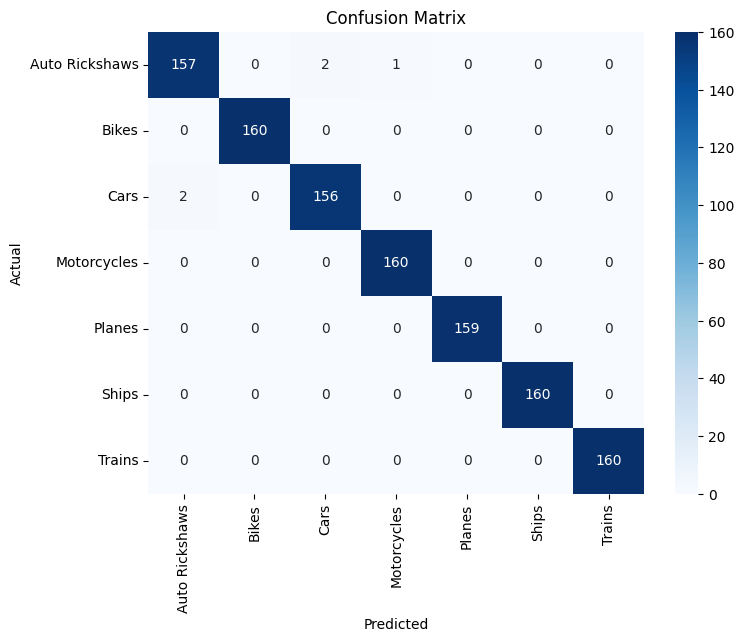

In [63]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Classification report**

In [64]:
print(classification_report(y_true, y_pred, target_names=class_names))

                precision    recall  f1-score   support

Auto Rickshaws       0.99      0.98      0.98       160
         Bikes       1.00      1.00      1.00       160
          Cars       0.99      0.99      0.99       158
   Motorcycles       0.99      1.00      1.00       160
        Planes       1.00      1.00      1.00       159
         Ships       1.00      1.00      1.00       160
        Trains       1.00      1.00      1.00       160

      accuracy                           1.00      1117
     macro avg       1.00      1.00      1.00      1117
  weighted avg       1.00      1.00      1.00      1117



# **Making Predictions on Validation Images (Visual)**

In [66]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def show_predictions(generator, model, num_images=5):
    indices = random.sample(range(len(generator.filenames)), num_images)

    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(indices):
        img_path = generator.filepaths[idx]
        true_label = class_names[generator.classes[idx]]

        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array)
        pred_label = class_names[np.argmax(pred)]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {pred_label}")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


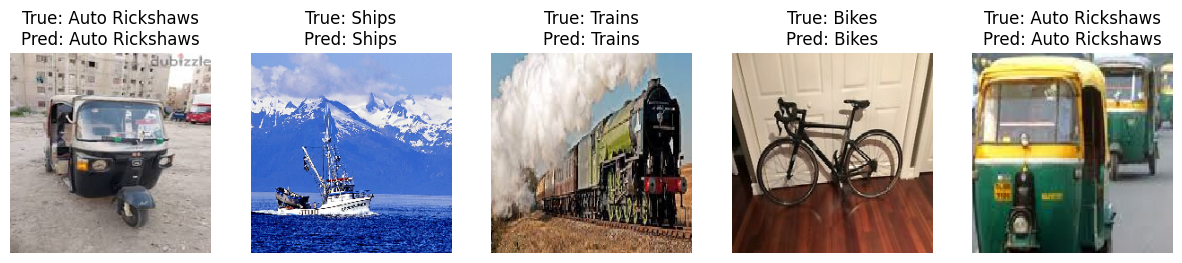

In [67]:
show_predictions(val_generator, model, num_images=5)

# **Making Predictions on Custom Data**

In [71]:
from google.colab import files

uploaded = files.upload()

Saving test1.jpg to test1 (1).jpg
Saving test2.jpg to test2.jpg


In [72]:
def predict_uploaded_images(model, uploaded_files):
    for file_name in uploaded_files.keys():
        img = tf.keras.utils.load_img(file_name, target_size=IMG_SIZE)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        preds = model.predict(img_array)
        pred_class = class_names[np.argmax(preds)]
        confidence = np.max(preds)

        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction: {pred_class}\nConfidence: {confidence:.2f}")
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


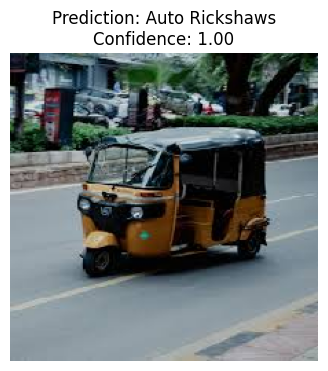

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


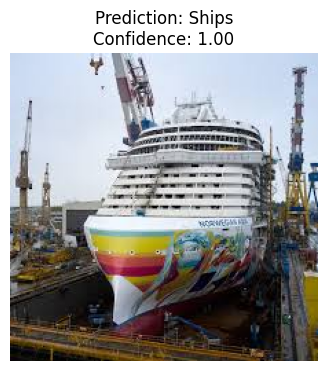

In [73]:
predict_uploaded_images(model, uploaded)